<a href="https://colab.research.google.com/github/CaseySobon/Image-recognition/blob/main/image_recognition_with_latent_spaces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf



In [ ]:
from keras.layers import Input, Dense, Lambda
from keras.models import Model, Sequential
from keras.losses import binary_crossentropy
from keras.callbacks import LearningRateScheduler

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import keras.backend as K
from tensorflow import keras

In [ ]:
# Visualization
import matplotlib
import matplotlib.pyplot as plt
import graphviz
import plotly
import plotly.express as px
from tensorflow.keras.utils import plot_model

In [ ]:
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [ ]:
#Normalize data
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


In [ ]:
# Specify dimensions for input/output and latent space layers
original_dim = 784 # number of neurons at the input layer (28 * 28 = 784)
latent_dim = 2 # latent space dimension

In [ ]:
#--- Create a function, which we will use to randomly sample from latent space distribution
# Note, epsilon is sampled from a standard normal distribution and is used to maintain the required stochasticity of Z
# Meanwhile, z-mean and z-sigma remain deterministic allowing the loss to backpropagate through the layers.
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon


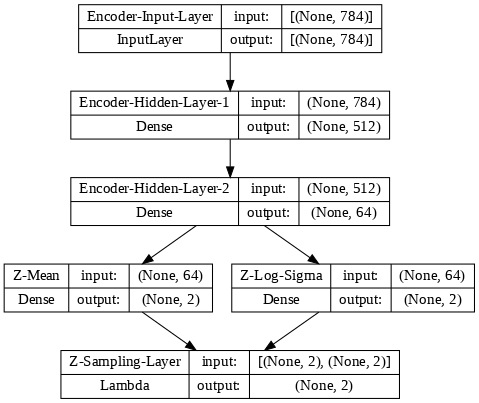

In [ ]:
# ********** Create Encoder **********

#--- Input Layer
visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

#--- Hidden Layer
h_enc1 = Dense(units=512, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
#h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

#--- Custom Latent Space Layer
z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc2) # Mean component
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc2) # Standard deviation component
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma]) # Z sampling layer

#--- Create Encoder model
encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

# Display model diagram
plot_model(encoder, show_shapes=True, dpi=75)

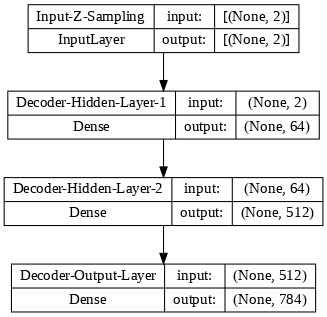

In [ ]:
# ********** Create Decoder **********

#--- Input Layer
latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

#--- Hidden Layer
h_dec = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=512, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)


#--- Output Layer
outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec2)

#--- Create Decoder model
decoder = Model(latent_inputs, outputs, name='Decoder-Model')

# Display model diagram
plot_model(decoder, show_shapes=True, dpi=75)

In [ ]:
# Define outputs from a VAE model by specifying how the encoder-decoder models are linked
outpt = decoder(encoder(visible)[2]) # note, outputs available from encoder model are z_mean, z_log_sigma and z. We take z by specifying [2]
# Instantiate a VAE model
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

In [ ]:
# Reconstruction loss compares inputs and outputs and tries to minimise the difference
r_loss = original_dim * keras.losses.mse(visible, outpt)  # use MSE

# KL divergence loss compares the encoded latent distribution Z with standard Normal distribution and penalizes if it's too different
kl_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)

# The VAE loss is a combination of reconstruction loss and KL loss
vae_loss = K.mean(r_loss + kl_loss)

# Add loss to the model and compile it
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Epoch 1/10
1200/1200 [==============================] - 23s 18ms/step - loss: 45.2642 - val_loss: 39.6118
Epoch 2/10
1200/1200 [==============================] - 22s 19ms/step - loss: 38.6156 - val_loss: 37.3446
Epoch 3/10
1200/1200 [==============================] - 24s 20ms/step - loss: 36.7413 - val_loss: 36.3493
Epoch 4/10
1200/1200 [==============================] - 23s 19ms/step - loss: 35.6245 - val_loss: 34.9921
Epoch 5/10
1200/1200 [==============================] - 22s 18ms/step - loss: 34.8158 - val_loss: 34.4842
Epoch 6/10
1200/1200 [==============================] - 24s 20ms/step - loss: 34.1940 - val_loss: 33.8468
Epoch 7/10
1200/1200 [==============================] - 22s 18ms/step - loss: 33.7053 - val_loss: 33.5719
Epoch 8/10
1200/1200 [==============================] - 23s 19ms/step - loss: 33.3243 - val_loss: 33.4038
Epoch 9/10
1200/1200 [==============================] - 23s 19ms/step - loss: 32.9869 - val_loss: 33.0386
Epoch 10/10
1200/1200 [=======================

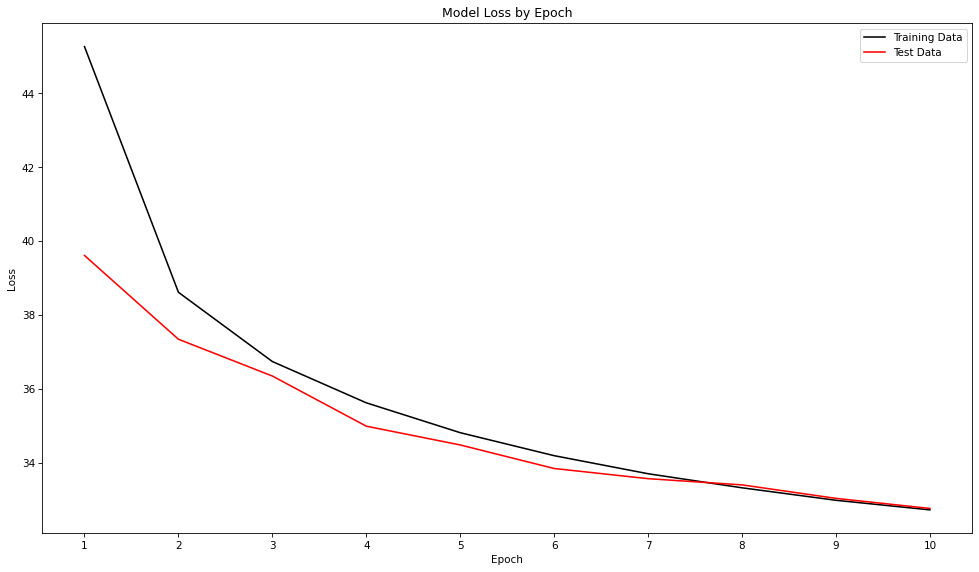

In [ ]:
# Train VAE model
history = vae.fit(x_train, x_train, epochs=10, batch_size=50, validation_data=(x_test, x_test))

# Plot a loss chart
fig, ax = plt.subplots(figsize=(16,9), dpi=75)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

In [ ]:
# Use encoder model to encode inputs into a latent space
X_test_encoded = encoder.predict(x_test)

# Recall that our encoder returns 3 arrays: z-mean, z-log-sigma and z. We plot the values for z
# Create a scatter plot
fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1],
                 opacity=1, color=y_test.astype(str))

# Change chart background color
fig.update_layout(dict(plot_bgcolor = 'white'))

# Update axes lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white',
                 zeroline=True, zerolinewidth=1, zerolinecolor='white',
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white',
                 zeroline=True, zerolinewidth=1, zerolinecolor='white',
                 showline=True, linewidth=1, linecolor='white',
                 title_font=dict(size=10), tickfont=dict(size=10))

# Set figure title
fig.update_layout(title_text="MNIST digit representation in the 2D Latent Space")

# Update marker size
fig.update_traces(marker=dict(size=2))

fig.show()

313/313 [==============================] - 1s 3ms/step


1/1 [==============================] - 0s 25ms/step


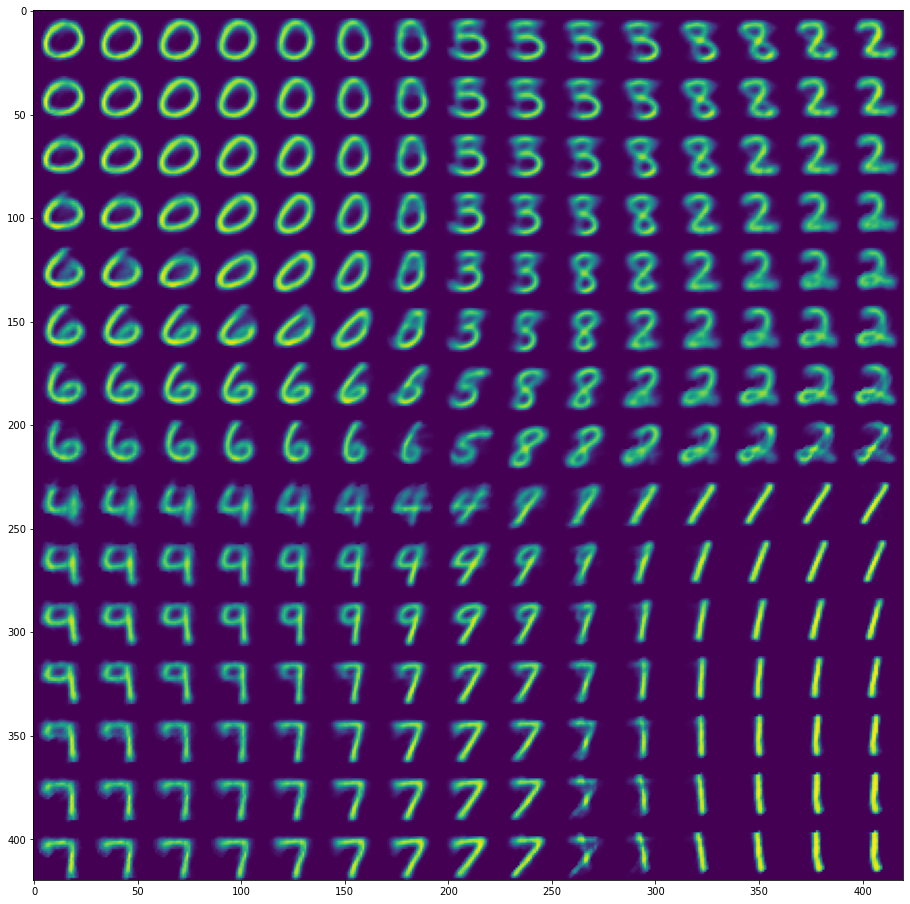

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# We will sample n points within [-1.5, 1.5] standard deviations
grid_x = np.linspace(1.5, -1.5, n)
grid_y = np.linspace(-1.5, 1.5, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        # Generate an image using a decoder model
        x_decoded = decoder.predict(z_sample)
        #x_decoded = np.clip(x_decoded, 0.25, 0.75) # we could use cliping to make digit edges thicker

        # Reshape from 784 to original digit size (28x28)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot figure
plt.figure(figsize=(18, 16))
plt.imshow(figure)
plt.show()